**Information**

***Tire offsets***  
Generally the offset from soft to medium tires is +0.6  
Generally the offset from medium to hard tires is +0.7

***Tire wear***
Generally:
- C1: 30-50
- C2: 25-35
- C3: 20-30
- C4: 15-25
- C5: 10-15

***Downforce***  
- High downforce: More stress on the tires, more tire wear  
- Low downforce: Less stress on the tires, less tire wear

***Available tire sets during a race***
- 2 scrubbed soft
- 2 new medium
- 1 new hard
- 1 scrubbed hard

**Probability of decay**
- Softs (10 - 25): 1% for the first 10 laps, 2% for the next 10 laps, 4% for the next 5 laps, puncture region post this.
- Mediums (20 - 35): 0.5% for the first 10 laps, 1% for the next 10 laps, 2% for the next 10 laps, 3% for the next 5, puncture region post this.
- Hards (25-50): 0.2% for the first 10, 0.5% for the next 10, 1% for the next 10, 1.5% for the next 10, 2% for the next 10, puncture region post this. 

**Logic**  
***Outcome:*** Find the fastest time for the entire race

In [38]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1.plotting
import scipy.stats as sts

In [39]:
# load the sessions
practice_1 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP1')
practice_2 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP2')
practice_3 = fastf1.get_session(2021, 'Monaco Grand Prix', 'FP3')

practice_1.load()
practice_2.load()
practice_3.load()

core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.1.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '11', '14', '16', '18', '22', '3', '31', '33', '4', '44', '47', '5', '55', '6', '63', '7', '77', '9', '99']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.1.3]
req            INFO 	Using cached 

In [40]:
def data_pre_processing(df):
    '''
    This function takes in a dataframe and converts the time columns to seconds, replace nan values, and adds a new columns

    Parameters:
    df (dataframe): dataframe to be processed

    Returns:
    df (dataframe): processed dataframe
    '''
    # convert the time columns to seconds
    convert_to_seconds = lambda x: x.total_seconds() if pd.Timedelta == type(x) else x
    df = df.applymap(convert_to_seconds)
    # replace nan values with None
    df.replace({np.nan: None}, inplace=True)
    # set a new column "Pit" to True if the PitOutTime is not null or PitInTime is not null
    df['Pit'] = df['PitOutTime'].notnull() | df['PitInTime'].notnull()
    return df

def practice_subset(df):
    '''
    This function takes in a dataframe and returns a subset of the dataframe

    Parameters:
    df (dataframe): dataframe to be processed

    Returns:
    df (dataframe): subset of the dataframe
    '''
    return df[['Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
               'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
               'IsPersonalBest', 'Compound', 'TyreLife', 'Team', 'Deleted', 'Pit']]

In [41]:
# retrieve the data for hamilton
hamilton_fp1 = practice_1.laps.pick_driver('HAM')
hamilton_fp2 = practice_2.laps.pick_driver('HAM')
hamilton_fp3 = practice_3.laps.pick_driver('HAM')
# process the data
hamilton_fp1 = data_pre_processing(hamilton_fp1)
hamilton_fp2 = data_pre_processing(hamilton_fp2)
hamilton_fp3 = data_pre_processing(hamilton_fp3)
# subset the columns
hamilton_fp1 = practice_subset(hamilton_fp1)
hamilton_fp2 = practice_subset(hamilton_fp2)
hamilton_fp3 = practice_subset(hamilton_fp3)
# remove pit laps
hamilton_fp1 = hamilton_fp1[hamilton_fp1['Pit'] == False]
hamilton_fp2 = hamilton_fp2[hamilton_fp2['Pit'] == False]
hamilton_fp3 = hamilton_fp3[hamilton_fp3['Pit'] == False]
# pick the quick laps
hamilton_fp1 = hamilton_fp1.pick_quicklaps()
hamilton_fp2 = hamilton_fp2.pick_quicklaps()
hamilton_fp3 = hamilton_fp3.pick_quicklaps()

In [42]:
# group the laps by compound for each practice session
hamilton_fp1_hard = hamilton_fp1[hamilton_fp1['Compound'] == 'HARD']
hamilton_fp1_medium = hamilton_fp1[hamilton_fp1['Compound'] == 'MEDIUM']
hamilton_fp1_soft = hamilton_fp1[hamilton_fp1['Compound'] == 'SOFT']

hamilton_fp2_hard = hamilton_fp2[hamilton_fp2['Compound'] == 'HARD']
hamilton_fp2_medium = hamilton_fp2[hamilton_fp2['Compound'] == 'MEDIUM']
hamilton_fp2_soft = hamilton_fp2[hamilton_fp2['Compound'] == 'SOFT']

hamilton_fp3_hard = hamilton_fp3[hamilton_fp3['Compound'] == 'HARD']
hamilton_fp3_medium = hamilton_fp3[hamilton_fp3['Compound'] == 'MEDIUM']
hamilton_fp3_soft = hamilton_fp3[hamilton_fp3['Compound'] == 'SOFT']

# Concatenate all the practice sessions
hamilton_practice_hard = pd.concat([hamilton_fp1_hard, hamilton_fp2_hard, hamilton_fp3_hard])
hamilton_practice_medium = pd.concat([hamilton_fp1_medium, hamilton_fp2_medium, hamilton_fp3_medium])
hamilton_practice_soft = pd.concat([hamilton_fp1_soft, hamilton_fp2_soft, hamilton_fp3_soft])

In [43]:
# find the means and standard deviations of the lap times on each compound
hamilton_hard_mean = hamilton_practice_hard['LapTime'].mean()
hamilton_hard_std = hamilton_practice_hard['LapTime'].std()

hamilton_medium_mean = hamilton_practice_medium['LapTime'].mean()
hamilton_medium_std = hamilton_practice_medium['LapTime'].std()

hamilton_soft_mean = hamilton_practice_soft['LapTime'].mean()
hamilton_soft_std = hamilton_practice_soft['LapTime'].std()

In [44]:
# print out the means and standard deviations
print('Hamilton Hard Mean: ', hamilton_hard_mean)
print('Hamilton Hard Standard Deviation: ', hamilton_hard_std)
print('Hamilton Medium Mean: ', hamilton_medium_mean)
print('Hamilton Medium Standard Deviation: ', hamilton_medium_std)
print('Hamilton Soft Mean: ', hamilton_soft_mean)
print('Hamilton Soft Standard Deviation: ', hamilton_soft_std)

Hamilton Hard Mean:  75.47775
Hamilton Hard Standard Deviation:  0.7065015923548936
Hamilton Medium Mean:  73.57271428571428
Hamilton Medium Standard Deviation:  1.0536978874873162
Hamilton Soft Mean:  72.34433333333334
Hamilton Soft Standard Deviation:  0.4677420941786932


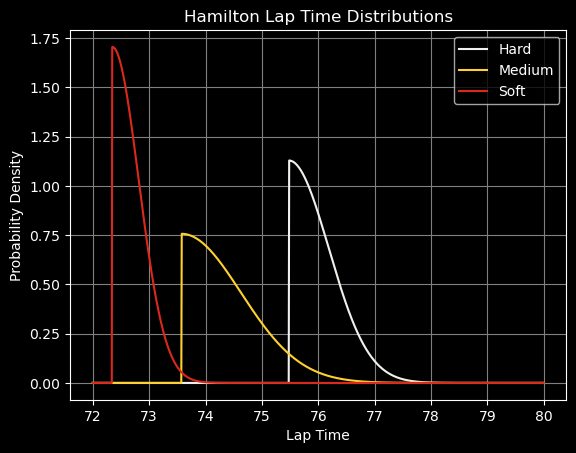

In [45]:
# define distributions for each compound
hamilton_hard_dist = sts.halfnorm(hamilton_hard_mean, hamilton_hard_std)
hamilton_medium_dist = sts.halfnorm(hamilton_medium_mean, hamilton_medium_std)
hamilton_soft_dist = sts.halfnorm(hamilton_soft_mean, hamilton_soft_std)

# plot the distributions
# set the background to be black
plt.style.use('dark_background')
# set grid lines to be grey
plt.rcParams['grid.color'] = 'grey'
# show grid lines
plt.grid(True)
# set the range of lap times / values that the distributions will be plotted over
x = np.linspace(72, 80, 1000)
# plot the pdfs
plt.plot(x, hamilton_hard_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['HARD'], label='Hard')
plt.plot(x, hamilton_medium_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['MEDIUM'], label='Medium')
plt.plot(x, hamilton_soft_dist.pdf(x), color = fastf1.plotting.COMPOUND_COLORS['SOFT'], label='Soft')
plt.legend()
plt.xlabel('Lap Time')
plt.ylabel('Probability Density')
plt.title('Hamilton Lap Time Distributions')
plt.show()

In [ ]:
'''

TO DO: Refactor code to make it more interpretable and avoid repeating code

IN PROGRESS

'''
# def create_halfnorm_distribution(loc, scale):
#     return sts.halfnorm(loc, scale, size)

# def tire_wear(laps, threshold_value, wear_dist_dict):
#     tire_wears = []
#     tire_performance = [1]
#     counter = 0

#     while tire_performance[-1] > threshold_value and counter < laps:
#         current_tire_life = tire_performance[-1]
#         wear_dist_key = find_distribution_key(counter)
#         tire_wears.append(wear_dist_dict[wear_dist_key].rvs() / 100)
#         current_tire_life -= tire_wears[counter]
#         tire_performance.append(current_tire_life)
#         counter += 1

#     tire_performance.pop()
#     return tire_wears, tire_performance

# def find_distribution_key(counter):
#     if counter < 10:
#         return '10'
#     elif counter < 20:
#         return '10_to_20'
#     elif counter < 30:
#         return '20_to_30'
#     elif counter < 40:
#         return '30_to_40'
#     else:
#         return 'after_40'

# # Define tire wear distributions
# wear_dist_dict = {
#     'hard': {
#         '10': create_halfnorm_distribution(0.2),
#         '10_to_20': create_halfnorm_distribution(0.5),
#         '20_to_30': create_halfnorm_distribution(1),
#         '30_to_40': create_halfnorm_distribution(1.5),
#         'after_40': create_halfnorm_distribution(2),
#     },
#     'medium': {
#         '10': create_halfnorm_distribution(0.5),
#         '10_to_20': create_halfnorm_distribution(1, 0.3),
#         '20_to_30': create_halfnorm_distribution(2, 0.4),
#         'after_30': create_halfnorm_distribution(3, 0.5),
#     },
#     'soft': {
#         '10': create_halfnorm_distribution(1, 0.3),
#         '10_to_20': create_halfnorm_distribution(2, 0.4),
#         'after_20': create_halfnorm_distribution(4, 0.5),
#     }
# }

# # Example usage:
# tire_wears_hard, tire_performance_hard = tire_wear(50, 0.1, wear_dist_dict['hard'])
# tire_wears_medium, tire_performance_medium = tire_wear(50, 0.1, wear_dist_dict['medium'])
# tire_wears_soft, tire_performance_soft = tire_wear(50, 0.1, wear_dist_dict['soft'])

In [46]:
# define distributions for the tire wear on each tire
hard_wear_dist_10 = sts.halfnorm(0.2, 0.1)
hard_wear_dist_10_to_20 = sts.halfnorm(0.5, 0.2)
hard_wear_dist_20_to_30 = sts.halfnorm(1, 0.2)
hard_wear_dist_30_to_40 = sts.halfnorm(1.5, 0.2)
hard_wear_dist_after_40 = sts.halfnorm(2, 0.2)

medium_wear_dist_10 = sts.halfnorm(0.5, 0.2)
medium_wear_dist_10_to_20 = sts.halfnorm(1, 0.3)
medium_wear_dist_20_to_30 = sts.halfnorm(2, 0.4)
medium_wear_dist_after_30 = sts.halfnorm(3, 0.5)

soft_wear_dist_10 = sts.halfnorm(1, 0.3)
soft_wear_dist_10_to_20 = sts.halfnorm(2, 0.4)
soft_wear_dist_after_20 = sts.halfnorm(4, 0.5)

In [98]:
def tire_wear_hard(laps, threshold_value):
    '''
    This function takes in the number of laps and the threshold value and returns the tire wears and tire performance for the hard compound

    Parameters:
    laps (int): number of laps to run
    threshold_value (float): threshold value for the tire performance

    Returns:
    tire_wears (list): list of tire wears
    tire_performance (list): list of tire performance
    '''
    # initialize the lists and counter
    tire_wears = []
    tire_performance = [1]
    counter = 0
    # run until tire reaches threshold or counter reaches laps
    while tire_performance[-1] > threshold_value and counter < laps:
        # set the current tire performance
        current_tire_life = tire_performance[-1]
        # find the right distribution to use based on the counter, then append tire wear, update tire performance, and increment counter
        if counter < 10:
            tire_wears.append(hard_wear_dist_10.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 20:
            tire_wears.append(hard_wear_dist_10_to_20.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 30:
            tire_wears.append(hard_wear_dist_20_to_30.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 40:
            tire_wears.append(hard_wear_dist_30_to_40.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        else:
            tire_wears.append(hard_wear_dist_after_40.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1

    # remove the last element from tire performance because it is always less than the threshold value
    tire_performance.pop()

    return tire_wears, tire_performance


def tire_wear_medium(laps, threshold_value):
    '''
    This function takes in the number of laps and the threshold value and returns the tire wears and tire performance for the medium compound

    Parameters:
    laps (int): number of laps to run
    threshold_value (float): threshold value for the tire performance

    Returns:
    tire_wears (list): list of tire wears
    tire_performance (list): list of tire performance
    '''
    # initialize the lists and counter
    tire_wears = []
    tire_performance = [1]
    counter = 0
    # run until tire reaches threshold or counter reaches laps
    while tire_performance[-1] > threshold_value and counter < laps:
        # set the current tire performance
        current_tire_life = tire_performance[-1]
        # find the right distribution to use based on the counter, then append tire wear, update tire performance, and increment counter
        if counter < 10:
            tire_wears.append(medium_wear_dist_10.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 20:
            tire_wears.append(medium_wear_dist_10_to_20.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 30:
            tire_wears.append(medium_wear_dist_20_to_30.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        else:
            tire_wears.append(medium_wear_dist_after_30.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1

    # remove the last element from tire performance because it is always less than the threshold value
    tire_performance.pop()
    
    return tire_wears, tire_performance

def tire_wear_soft(laps, threshold_value):
    '''
    This function takes in the number of laps and the threshold value and returns the tire wears and tire performance for the soft compound

    Parameters:
    laps (int): number of laps to run
    threshold_value (float): threshold value for the tire performance

    Returns:
    tire_wears (list): list of tire wears
    tire_performance (list): list of tire performance
    '''
    # initialize the lists and counter
    tire_wears = []
    tire_performance = [1]
    counter = 0
    # run until tire reaches threshold or counter reaches laps
    while tire_performance[-1] > threshold_value and counter < laps:
        # set the current tire performance
        current_tire_life = tire_performance[-1]
        # find the right distribution to use based on the counter, then append tire wear, update tire performance, and increment counter
        if counter < 10:
            tire_wears.append(soft_wear_dist_10.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        elif counter < 20:
            tire_wears.append(soft_wear_dist_10_to_20.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1
        else:
            tire_wears.append(soft_wear_dist_after_20.rvs()/100)
            current_tire_life -= tire_wears[counter]
            tire_performance.append(current_tire_life)
            counter += 1

    # remove the last element from tire performance because it is always less than the threshold value
    tire_performance.pop()
    
    return tire_wears, tire_performance

In [99]:
class Race:
    '''
    This class runs the simulation of the race and keeps track of all attributes associated with the race
    '''
    def __init__(self, proposed_tires, pit_time_lost, laps, threshold_value = 0.5):
        '''
        Intializes the class with the proposed tires, pit time lost, laps, and threshold value

        Parameters:
        proposed_tires (list): list of proposed tires
        pit_time_lost (float): time lost in the pit
        laps (int): number of laps to run
        '''
        self.proposed_tires = proposed_tires
        self.pit_time_lost = pit_time_lost
        self.threshold_value = threshold_value
        self.laps = laps
        # self.distribution_hard = hamilton_hard_dist
        # self.distribution_medium = hamilton_medium_dist
        # self.distribution_soft = hamilton_soft_dist
        # intialize the attributes to keep track of
        self.stints = {}
        self.lap_times = []
        self.tire_performance = []
        self.total_time = 0

    def run(self):
        '''
        This function runs the simulation for the entire race and updates the attributes accordingly

        Parameters:
        None

        Returns:
        None
        '''
        # loop through the proposed tires
        for tire in self.proposed_tires:
            # if this isn't the first tire, add pit stop time to the total time
            if self.total_time != 0:
                self.total_time += self.pit_time_lost
            # get the proposed tire wear values for the tire and the right lap time distribution
            if tire == "HARD":
                proposed_tire_wears, proposed_tire_performance = tire_wear_hard(self.laps, self.threshold_value)
                lap_time_dist = hamilton_hard_dist
            elif tire == "MEDIUM":
                proposed_tire_wears, proposed_tire_performance = tire_wear_medium(self.laps, self.threshold_value)
                lap_time_dist = hamilton_medium_dist
            else:
                proposed_tire_wears, proposed_tire_performance = tire_wear_soft(self.laps, self.threshold_value)
                lap_time_dist = hamilton_soft_dist
            # set the stint length
            stint_length = len(proposed_tire_wears)
            # sample the lap times
            proposed_lap_times = lap_time_dist.rvs(stint_length)
            # append the lap times and tire performance to the lists
            for time in proposed_lap_times:
                self.lap_times.append(time)
            for performance in proposed_tire_performance:
                self.tire_performance.append(performance)
            # update the number of laps left
            self.laps -= stint_length
            # add the stint to the dictionary
            self.stints.update({tire: stint_length})
            # update the total_time variable to include the lap times for the stint
            self.total_time += sum(proposed_lap_times)


In [100]:
# demonstration of the simulation for the Monaco Grand Prix
Monaco = Race(['MEDIUM', 'SOFT', 'HARD'], 22, 78, threshold_value=0.7)
Monaco.run()
Monaco.stints

{'MEDIUM': 25, 'SOFT': 18, 'HARD': 35}

In [103]:
# get the lap times and tire performance
lap_times = Monaco.lap_times
tire_performance = Monaco.tire_performance
# get the compounds from the stints
compounds = []
for key in Monaco.stints:
    for i in range(Monaco.stints[key]):
        compounds.append(key)

# make a dataframe of the lap times and compounds
lap_times_df = pd.DataFrame({'Lap Times': lap_times, 'Compound': compounds, 'Tire Performance': tire_performance})
lap_times_df

,Lap Times,Compound,Tire Performance
0,73.957860,MEDIUM,1.000000
1,73.576575,MEDIUM,0.992772
2,74.307248,MEDIUM,0.987647
3,74.113015,MEDIUM,0.979113
4,73.781616,MEDIUM,0.972838
...,...,...,...
73,75.667466,HARD,0.780784
74,75.730063,HARD,0.763096
75,76.793233,HARD,0.746880
76,75.530724,HARD,0.730947


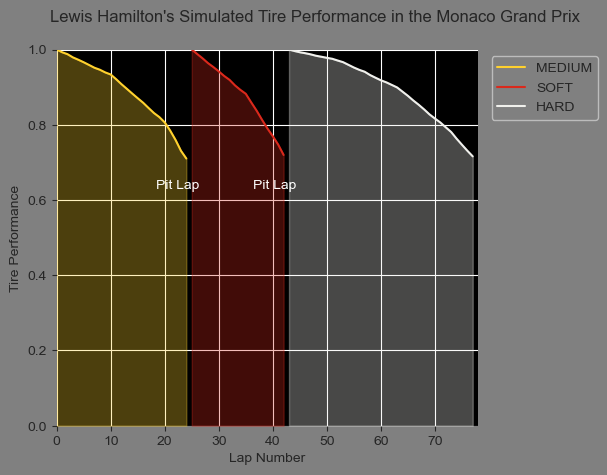

In [126]:
# set the background to be black to make the colors easier to read and standardize the style
sns.set_style("ticks", rc = {"axes.facecolor": "black", "figure.facecolor": "grey"})
fig, ax = plt.subplots()

# get the unique compounds
compounds = lap_times_df['Compound'].unique()

# for each compound, plot the line and fill the area under the line
for compound in compounds:
    df = lap_times_df[lap_times_df['Compound'] == compound]
    line = ax.plot(df.index, df['Tire Performance'], label=compound, color = fastf1.plotting.COMPOUND_COLORS[compound])
    ax.fill_between(df.index, df['Tire Performance'], color=line[0].get_color(), alpha=0.3)

# annotate pit stops
previous_compound = lap_times_df['Compound'].iloc[0]
for i in range(1, len(lap_times_df)):
    current_compound = lap_times_df['Compound'].iloc[i]
    if current_compound != previous_compound:
        ax.annotate('Pit Lap', (i, lap_times_df['Tire Performance'].iloc[i]), textcoords="offset points",
                    color = "white", xytext=(-10,-100), ha='center')
    previous_compound = current_compound

# set the x and y limits, labels, and title
ax.set_xlim(0, 78)
ax.set_ylim(0, 1)
ax.set_xlabel("Lap Number")
ax.set_ylabel("Tire Performance")
plt.suptitle(f"Lewis Hamilton's Simulated Tire Performance in the Monaco Grand Prix")
plt.grid(color = "w", which = 'major', axis = 'both')
sns.despine(left = True, bottom = True)

plt.legend()
# get the plot's legend
leg = ax.get_legend()
# put the legend out of the plot
leg.set_bbox_to_anchor((1.3, 1))
# set the legend's background to transparent
frame = leg.get_frame()
frame.set_facecolor('none')
plt.tight_layout()
plt.show()

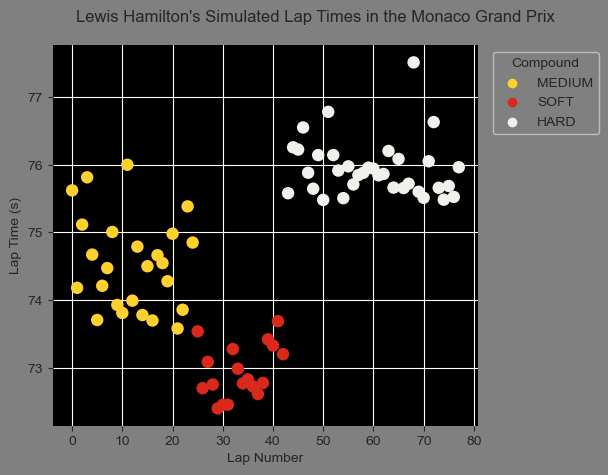

In [80]:
sns.set_style("ticks", rc = {"axes.facecolor": "black", "figure.facecolor": "grey"})
fig, ax = plt.subplots()
# make a scatterplot of the lap times that have been simulated for the Monaco Grand Prix
sns.scatterplot(data = lap_times_df, x = lap_times_df.index, y = "Lap Times", 
                ax = ax, hue = "Compound", palette = fastf1.plotting.COMPOUND_COLORS,
                s = 80, linewidth = 0, legend = "auto")
# set labels and title
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time (s)")
plt.suptitle(f"Lewis Hamilton's Simulated Lap Times in the Monaco Grand Prix")
plt.grid(color = "w", which = 'major', axis = 'both')
sns.despine(left = True, bottom = True)
# get the plot's legend
leg = ax.get_legend()
# put the legend out of the plot
leg.set_bbox_to_anchor((1.3, 1))
# set the legend's background to transparent
frame = leg.get_frame()
frame.set_facecolor('none')
plt.tight_layout()
plt.show()

In [127]:
# get the actual race session
race = fastf1.get_session(2021, 'Monaco Grand Prix', 'R')
race.load()

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.1.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cac

In [145]:
# retrieve the results
results = race.results
# find the time from the actual race
race_time = results[0:1].Time
# convert the time to minutes
actual_time = race_time.iloc[0].total_seconds()/60
# get the predicted time from the simulation
predicted_time = Monaco.total_time/60
# print the values for comparison
print(f"During the race, the finish time was {actual_time : 2f} minutes")
print(f"The predicted finish time was {predicted_time: 2f} minutes")

During the race, the finish time was  98.947000 minutes
The predicted finish time was  97.822825 minutes
